Import niezbędnych bibliotek

In [ ]:
!pip install python-igraph==0.8.3
!apt install libcairo2-dev pkg-config python3-dev
!pip install python-igraph leidenalg cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev
  libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev
  libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils
The following NEW packages will be installed:
  

In [ ]:
import tweepy
import time
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import igraph
from igraph import *
import cairocffi

Ustawienie logowania do API Twittera

In [ ]:
key = '9j53bwQhtgeirnxlFwKxYiazr'
key_secret= 'Op3znNtnQI3D4wJtUWrfYjtXPrW7AcqiWlcqtRwdl7Cybg4s1m'

auth = tweepy.OAuthHandler(key, key_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Pobranie danych z pliku csv (imię i nazwisko, nick, redakcja)

In [ ]:
df = pd.read_csv('dataset.csv')

Ściągnięcie z pomocą API pozostałych wymaganych danych z Twittera (id profilu, liczba obserwowanych, liczba obserwujących, lista obserwowanych dziennikarzy z analizowanego zbioru)

In [ ]:
def add_twitter_data(df):
  def basic_info(nick):
    id = 0
    followers_count = 0
    following_count = 0
    user = api.get_user(nick)
    id = user.id
    followers_count = user.followers_count
    following_count = user.friends_count
    return id, followers_count, following_count
  (df['id'], df['followers_count'], df['following_count']) = np.vectorize(basic_info, otypes = [object, object, object])(df['nick'])

  col_list = df.id.values.tolist()

  def following_list(nick):
    following = []
    user = api.get_user(nick)
    for i, _id in enumerate(tweepy.Cursor(api.friends_ids, screen_name = nick).items()):
      if _id in col_list:
        following.append(_id)
    return following
  (df['following']) = np.vectorize(following_list, otypes = [object])(df['nick'])
  return df

  df_tw = add_twitter_data(df)

Zapis DataFrame'u na dysku komputera

In [ ]:
df_tw.to_csv('output.csv')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Struktura głównego DataFrame'a



In [ ]:
df = pd.read_csv('output1.csv')
df.head()

,index,name,nick,media,id,followers_count,following_count,following1
0,0,Tomasz Ćwiąkała,cwiakala,CANAL,236586896,305783,1327,"[1057608774536609793, 1224740726, 759710584694..."
1,1,Andrzej Twarowski,TwaroTwaro,CANAL,2809623881,213982,228,"[365007636, 1128820086297583616, 1372073226, 1..."
2,2,Jakub Kręcidło,J_Krecidlo,CANAL,620925321,57485,1173,"[1128820086297583616, 1441449371350994944, 933..."
3,3,Bartosz Ignacik,BartekIgnacik,CANAL,1128820086297583616,19204,384,"[620925321, 1437825697, 933081649, 365007636, ..."
4,4,Edward Durda,DurdaEdward,CANAL,1441449371350994944,12334,71,"[2809623881, 43061493, 1183133300, 2691092842,..."


Wyznaczenie 10 najpopularniejszych (pod względem liczby obserwujących) dziennikarzy z badanego zbioru i przygotowanie na tej podstawie wykresu słupkowego

In [ ]:
df_most_followers = df[['name', 'followers_count']].sort_values(by=['followers_count'], ascending=False).head(10)
df_most_followers

,name,followers_count
6,Mateusz Borek,815790
7,Krzysztof Stanowski,779933
8,Michał Pol,648999
0,Tomasz Ćwiąkała,305783
38,Wojciech Kowalczyk,228657
9,Tomasz Smokowski,223609
1,Andrzej Twarowski,213982
13,Mateusz Święcicki,161832
14,Łukasz Wiśniowski,152293
15,Tomasz Włodarczyk,148869


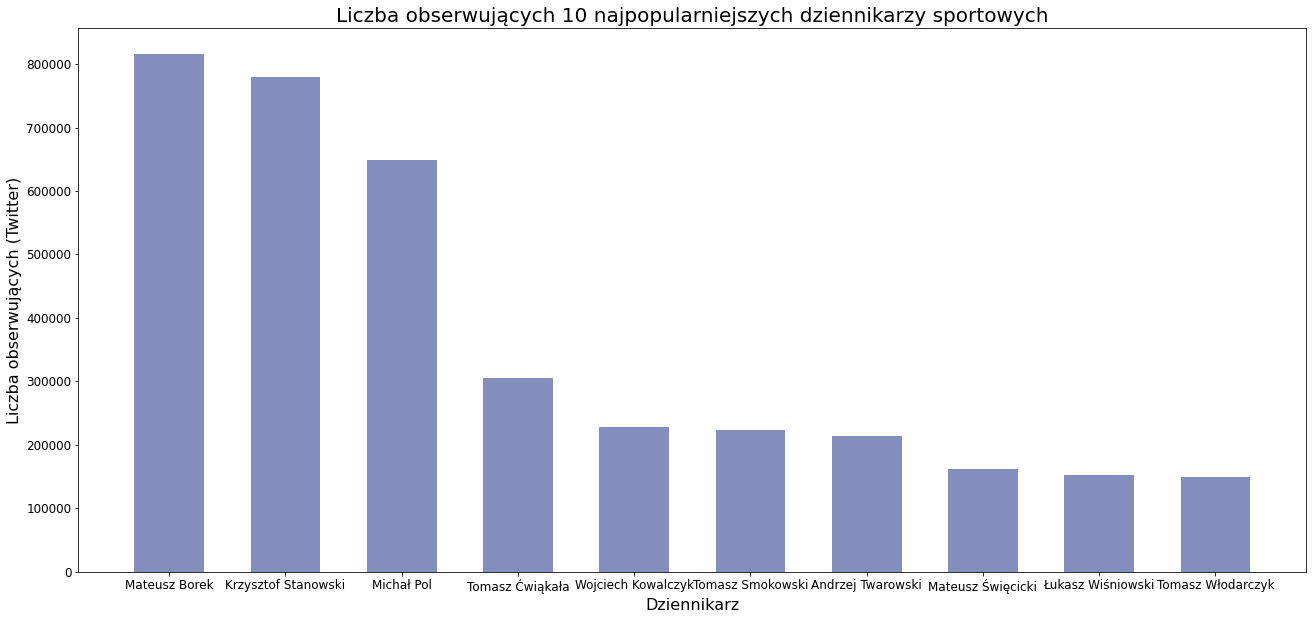

In [ ]:
fig = plt.figure(figsize = (22, 10))
plt.rcParams['font.size'] = 12
plt.bar(df_most_followers['name'], df_most_followers['followers_count'], color ='#838EBE', width = 0.6)
plt.xlabel('Dziennikarz', fontsize=16)
plt.ylabel('Liczba obserwujących (Twitter)', fontsize=16)
plt.title('Liczba obserwujących 10 najpopularniejszych dziennikarzy sportowych', fontsize=20)
plt.show()

Wyznaczenie średniej liczby obserwujących dziennikarzy z poszczególnych redakcji i przedstawienie ich na wykresie słupkowym

In [ ]:
df_red_followers_count= df.groupby(['media'])['media'].count()
print(df_red_followers_count)

media
CANAL       6
KS          7
MECZYKI    14
TVP         5
VP          6
WESZLO     13
Name: media, dtype: int64


In [ ]:
df_red_followers_sum= df[['media', 'followers_count']].groupby(by=['media'], as_index = False).sum([['followers_count']])
df_red_followers_sum['users_count'] = [6, 7, 14, 5, 6, 13]
df_red_followers_avg = df_red_followers_sum.assign(avg_followers=lambda x: round(x['followers_count'] / x['users_count'], 0))
print(df_red_followers_avg)

     media  followers_count  users_count  avg_followers
0    CANAL           609580            6       101597.0
1       KS          2717114            7       388159.0
2  MECZYKI           777795           14        55557.0
3      TVP           102716            5        20543.0
4       VP           126596            6        21099.0
5   WESZLO           758047           13        58311.0


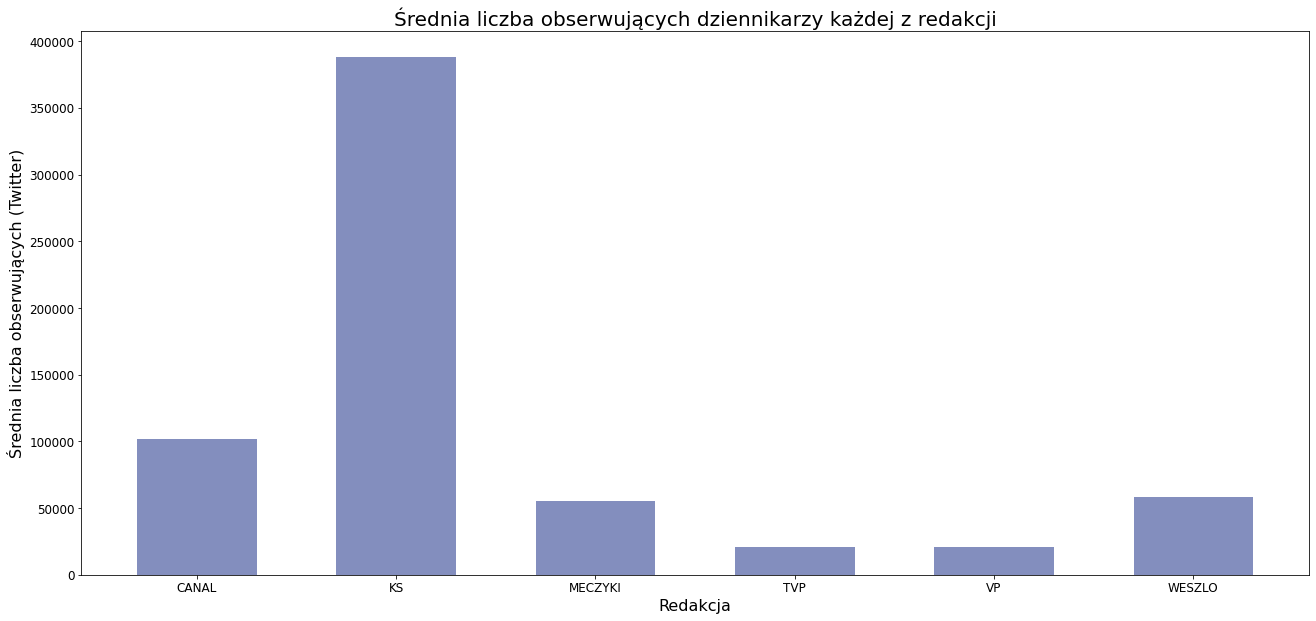

In [ ]:
fig = plt.figure(figsize = (22, 10))
plt.rcParams['font.size'] = 12
plt.ticklabel_format(style='plain')
plt.bar(df_red_followers_avg['media'], df_red_followers_avg['avg_followers'], color ='#838EBE', width = 0.6)
plt.xlabel('Redakcja', fontsize=16)
plt.ylabel('Średnia liczba obserwujących (Twitter)', fontsize=16)
plt.title('Średnia liczba obserwujących dziennikarzy każdej z redakcji', fontsize=20)
plt.show()

Poprawa kolumny z obserwowanymi dziennikarzami do struktury umożliwiającej wygenerowanie datasetu krawędzi

In [ ]:
def to_list(df):
  def to_list2(following1):
    following1 = following1.replace('[', '')
    following1 = following1.replace(']', '')
    following1 = following1.replace(' ', '')
    following_lst = following1.split(',')
    return following_lst
  df['following1'] = np.vectorize(to_list2, otypes = [object])(df['following1'])
  return df

df = to_list(df)

Przygotowanie datasetu węzłów

In [ ]:
df_nl = df[['name', 'id', 'media', 'followers_count', 'following_count']]

Przygotowanie datasetu krawędzi

In [ ]:
df_el = pd.DataFrame(columns = ['id1', 'id2', 'weight'])

for i, id1 in enumerate(list(df['id'])):
  following_list1 = df.loc[i,"following1"]
  for id2 in following_list1:
    df_el = df_el.append({'id1': int(id1), 'id2': int(id2)}, ignore_index=True)

df_el['weight'] = 1
df_el.head()

,id1,id2,weight
0,236586896.0,1.057609e+18,1
1,236586896.0,1.224741e+09,1
2,236586896.0,7.597106e+17,1
3,236586896.0,1.136300e+18,1
4,236586896.0,4.702754e+09,1


Zamiana id dziennikarzy na prostsze liczby (aliasy)

In [ ]:
id_list = list(df['id'])
alias_list = [*range(1, len(df.index) + 1, 1)]

for i, j in zip(id_list, alias_list):
  df_el = df_el.replace(i, j)
df_el = df_el.round(0)

for i, j in zip(id_list, alias_list):
  df_nl = df_nl.replace(i, j)
df_nl = df_nl.round(0)

Eksport datasetów węzłów oraz krawędzi do plików csv

In [ ]:
df_nl.to_csv('nl.csv')
df_el.to_csv('el.csv')

In [ ]:
a = Graph.TupleList(df_el.itertuples(index=False), directed=True, weights=False, edge_attrs="weight")

In [ ]:
tuple_el = [(list(df_el['id1']), list(df_el['id2'])) for i in range(0, len(list(df_el['id1'])))]

In [ ]:
c = Graph()
c.add_vertices(51)
c.vs['nm'] = list(df_nl['name'])
c.vs['media'] = list(df_nl['media'])
c.vs['followers_count'] = list(df_nl['followers_count'])
c.vs['following_count'] = list(df_nl['following_count'])
c.add_edges(tuple_el)

TypeError: ignored

In [ ]:
print(summary(c))
for i in c.vs:
  print(i)
for i in c.es:
  print(i)

IGRAPH U--- 51 0 -- 
+ attr: color (v), followers_count (v), following_count (v), media (v), nm (v)
None
igraph.Vertex(<igraph.Graph object at 0x7f852d7e0940>, 0, {'nm': 'Tomasz Ćwiąkała', 'media': 'CANAL', 'followers_count': 305783, 'following_count': 1327, 'color': 'green'})
igraph.Vertex(<igraph.Graph object at 0x7f852d7e0940>, 1, {'nm': 'Andrzej Twarowski', 'media': 'CANAL', 'followers_count': 213982, 'following_count': 228, 'color': 'green'})
igraph.Vertex(<igraph.Graph object at 0x7f852d7e0940>, 2, {'nm': 'Jakub Kręcidło', 'media': 'CANAL', 'followers_count': 57485, 'following_count': 1173, 'color': 'green'})
igraph.Vertex(<igraph.Graph object at 0x7f852d7e0940>, 3, {'nm': 'Bartosz Ignacik', 'media': 'CANAL', 'followers_count': 19204, 'following_count': 384, 'color': 'green'})
igraph.Vertex(<igraph.Graph object at 0x7f852d7e0940>, 4, {'nm': 'Edward Durda', 'media': 'CANAL', 'followers_count': 12334, 'following_count': 71, 'color': 'green'})
igraph.Vertex(<igraph.Graph object at 0

In [ ]:
color_dict = {'KS': 'black', 'WESZLO': 'orange', 'CANAL': 'green', 'TVP': 'blue', 'VP': 'purple', 'MECZYKI': 'red'}
c.vs['color'] = [color_dict[media] for media in c.vs['media']]
plot(c, layout="kk")

AttributeError: ignored